In [6]:
!pip3 install h5py
!pip3 install ipyparams


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1]:
from pathlib import Path
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import time
import os
from scipy import signal
import matplotlib.colors as colors
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import curve_fit
from scipy.special import erf
import scipy.io
import colorsys
from scipy import signal
import math
from scipy.stats import norm
import pickle
import os
import pandas as pd
from scipy.interpolate import interp1d


import ipyparams


<IPython.core.display.Javascript object>

Let's first make everything into methods

File mismatch glitch set-up

In [20]:
#run this the first time to spot any file offset glitches
# use jkam as the reference, as jkam typically doesn't miss
datastream_name='High NA Imaging'
working_path = Path.cwd().parent
data_path = datastream_name
file_prefix='jkam_capture'
path, dirs, files = next(os.walk( data_path ))
run_name = 'run1'

#Boolean input
override_num_shots = False
reset_hard = False #only set this to true if you want to reload from raw data


#number input
# num_shots_manual = 39
num_shots_manual = 286
num_frames = 3
point_name_inner = 'delta_pc (MHz)'
point_name_outer = 'pump power (uW)'
outer_zoom_factor = 5

def ControlV_Power(x,maximum_power=1):
    x_int=np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.7,1.8,1.9,2,2.2,2.5,2.75,3,3.25,3.5,4,4.5,5,6,7,8,9,10])
    y_int=np.array([0.01,0.05,0.37,1.61,4.6,10.33,19.55,32.62,49.72,70.12,93.72,119.12,145.82,174.32,203.32,232.32,288.52,311.92,
                    335.92,355.92,387.92,411.92,421.92,428.92,430.92,433.92,437.92,441.92,442.92,445.92,447.92,449.92,449.92,451.42])
    y_int=y_int/np.max(y_int)
    power_curve= interp1d(x_int,y_int,kind='slinear')
    return maximum_power*power_curve(x)


def compute_jkam_nums():
    tweezer_freq_list = 88 + 0.8*0 + 0.8*np.arange(40)
    atom_site = []
    for i in range(num_frames):
        atom_site.append(np.arange(len(tweezer_freq_list)))

    point_list_outer = ControlV_Power(np.array([0.9,1,1.1,1.15,1.2]), 145)
    point_list_inner = np.array([-2.45,-2.3,-2.15,-2,-1.85,-1.7,-1.55])
    point_parallel = False
    #################################################################################
    num_points_inner = len(point_list_inner)
    num_points_outer = len(point_list_outer)

    if num_points_inner == 1:
        point_list = np.array(point_list_outer)

    elif point_parallel == False:
        # zoom into outer product of outer product columns and an array of ones, 
        # add that to inner product of inner product columns and an array of ones, then flatten
        point_list = (outer_zoom_factor
                        *np.outer(point_list_outer,np.ones(len(point_list_inner))) 
                            + np.outer(np.ones(len(point_list_outer)),point_list_inner)).flatten()
    
    elif point_parallel == True:
        # just multiple the two lists
        point_list = np.arange(num_points_outer*num_points_inner)
        plt.plot(point_list)
    
    num_points = len(point_list)

    # get jkam reference lengths
    num_shots_jkam = len(files)
    num_shots = num_shots_jkam
    num_loops = num_shots//num_points
    num_tweezers = len(tweezer_freq_list)
    num_points = len(point_list)
    num_loops = num_shots//num_points + bool(num_shots%num_points)

    if override_num_shots:
        num_shots = num_shots_manual

    return num_shots, \
            num_loops, \
            num_points, \
            num_tweezers


def compute_jkam_creation_times():
    num_shots, num_loops, num_points, num_tweezers = compute_jkam_nums()

    # path, dirs, files = next(os.walk(data_path))
    # num_shots_fpga = len(files)
    # # num_shots = num_shots_fpga
    # if override_num_shots:
    #     num_shots = num_shots_manual
    jkam_creation_time_array =  np.zeros(num_shots)

    # store jkam creation times
    for shot_num in range(num_shots):    
        file_name = file_prefix+'_'+str(shot_num).zfill(5)+'.h5'
        jkam_creation_time_array[shot_num] = os.path.getctime(data_path+'/'+file_name)
        if shot_num%1000 ==0:
            print(shot_num)
    # compute the average gap time between shots
    avg_time_gap = (jkam_creation_time_array[-1]-jkam_creation_time_array[0])/(num_shots-1)

    return jkam_creation_time_array, avg_time_gap, num_shots

define params

In [21]:
reset_hard = True
currentnotebook_name = ipyparams.notebook_name
run_name = currentnotebook_name[:-6]
run_name = 'run0'
reset_gage = reset_hard
window='hann'
num_segments = 3
# reset_gage = True
time_me = True
plot_tenth_shot = True
het_freq = 20.000446 #MHz
dds_freq = het_freq / 2
samp_freq = 200 #MHz
# averaging_time = 100 #us
step_time = 1 #us
filter_time = 5 #us
voltage_conversion = 1000/32768 #in units of mV
kappa = 2*np.pi * 1.1 #MHz
LO_power = 314 #uW
PHOTON_ENERGY = 2.55e-19
LO_rate = 1e-12 * LO_power / PHOTON_ENERGY # count/us
photonrate_conversion = 1e-6/(4.64e7)/(22.36)/ PHOTON_ENERGY / (0.5*0.8) # count/us
#2e7 is the conversion gain, 2.55e-19 is single photon energy, the rest is the path efficiency
# 4.64e7 is the conversion gain for 116 Ohm load measured by network analyzer, 22.36 is from the amplifier
heterodyne_conversion = 1/np.sqrt(LO_rate) # np.sqrt(count/us)
cavity_conversion = 1/np.sqrt(kappa)
conversion_factor = voltage_conversion*photonrate_conversion*heterodyne_conversion*cavity_conversion
datastream_name_gage='gage'
working_path_gage = Path.cwd().parent
data_path_gage = datastream_name_gage
file_prefix_gage = 'gage_shot'
path, dirs, files = next(os.walk(data_path_gage))
num_shot_gage_start = 0
num_shots_gage = len(files)

if override_num_shots:
    num_shots_gage = num_shots_manual

loading

In [37]:

# turn above loading into a method
def get_shot_num(run_name, window, filter_time):
    try:
        num_shots_loaded = np.load(f'{run_name}_{window}_gage_cmplx_amp_{filter_time}_{step_time}.pkl', allow_pickle=True).shape[1]
    except FileNotFoundError:
        num_shots_loaded = 0
    try:
        np.load(f'{run_name}_{window}_gage_timebin_{filter_time}_{step_time}.pkl', allow_pickle=True)
    except FileNotFoundError:
        num_shots_loaded = 0

    return num_shots_loaded

def get_gage_creation_times(run_name, window, filter_time):
    num_shots = get_shot_num(run_name, window, filter_time)
    gage_creation_time_array =  np.zeros(num_shots)
    # get creation times and set file names
    for shot_num in range(num_shots):
        if shot_num < num_shots_gage:
            file_name = file_prefix_gage+'_'+str(shot_num).zfill(5)+'.h5'
            gage_creation_time_array[shot_num] = os.path.getctime(data_path_gage+'/'+file_name)
            if shot_num%1000 ==0:
                print(shot_num)
    return gage_creation_time_array, num_shots


def check_gage_file_mismatch(run_name, window, filter_time):
    #for my copied files, this doesn't really work so I'll comment most of it out for now
    jkam_creation_time_array, avg_time_gap, jkam_shots = compute_jkam_creation_times()
    gage_creation_time_array, gage_shots = get_gage_creation_times(run_name, window, filter_time)
    mask_valid_data_gage=np.zeros(len(jkam_creation_time_array))>1
    jkam_gage_matchlist=np.zeros(len(jkam_creation_time_array),dtype='int')-1
    gage_index_list=np.arange(len(gage_creation_time_array))

    for shot_num in range(gage_shots):
        time_temp = jkam_creation_time_array[shot_num]
        space_correct = True
        # check if the time difference between adjacent shots is within 30% of the average time gap
        if (shot_num>0) & \
            (np.abs(time_temp-jkam_creation_time_array[shot_num-1] - avg_time_gap)>0.3*avg_time_gap): 
            space_correct=False
            
        if (shot_num<(gage_shots-1)):
            if (np.abs(- time_temp+jkam_creation_time_array[shot_num+1] \
                    - avg_time_gap)>0.3*avg_time_gap): 
                space_correct=False
                
        if ((np.min(np.abs(gage_creation_time_array-time_temp)) <= 0.3*avg_time_gap)) & space_correct:
            mask_valid_data_gage[shot_num]=True
            jkam_gage_matchlist[shot_num]=gage_index_list[np.argmin(np.abs(gage_creation_time_array-time_temp))]
        else:
            print(f'error at {shot_num:d}')
            mask_valid_data_gage[shot_num]=False

        if shot_num%1000 ==0:
                print(shot_num)
    # set all entries to mask valid data to true
    mask_valid_data_gage = np.ones(len(jkam_creation_time_array))>0
    # fill jkam gage matchlist with 0s
    jkam_gage_matchlist = np.zeros(len(jkam_creation_time_array),dtype='int')
    return mask_valid_data_gage, jkam_gage_matchlist

In [42]:
def window_demod(hf, 
                 num_segments,
                 t0_list,
                 t0_idx_list,
                 ch1_pure_vec,
                 ch3_pure_vec,
                 cmplx_amp_array,
                 shot_num):
    for seg_num in range(num_segments):
        ch1 = np.array(hf[f'CH1_frame{seg_num}']) * conversion_factor #np.sqrt(n)
        ch3 = np.array(hf[f'CH3_frame{seg_num}']) * conversion_factor #np.sqrt(n)
        
        cmplx_amp_list_ch1=t0_list*0j
        cmplx_amp_list_ch3=t0_list*0j
        # apply filter functions to demodulate and compute complex amplitude
        for i,t0_idx in enumerate(t0_idx_list):
            t1_idx = t0_idx + filter_time*samp_freq
            if window=='flattop':
                w=signal.windows.flattop(t1_idx-t0_idx)
            elif window=='square':
                w=1
            elif window=='hann':
                w=signal.windows.hann(t1_idx-t0_idx)*2
            # elementwise multiplication of windowed signal and pure signal
            ch1_demod = np.multiply(ch1[t0_idx:t1_idx]*w, ch1_pure_vec[t0_idx:t1_idx])
            ch3_demod = np.multiply(ch3[t0_idx:t1_idx]*w, ch3_pure_vec[t0_idx:t1_idx])
            # perform integration
            ch1_demod_sum = np.cumsum(ch1_demod) #np.concatenate([[0],np.cumsum(ch1_demod)])
            ch3_demod_sum = np.cumsum(ch3_demod) # np.concatenate([[0],np.cumsum(ch3_demod)])
            # compute complex amplitude by taking the difference of the integrated signals over time
            cmplx_amp_list_ch1[i] = (ch1_demod_sum[-1] - ch1_demod_sum[0]) / (t1_idx-t0_idx)
            cmplx_amp_list_ch3[i] = (ch3_demod_sum[-1] - ch3_demod_sum[0]) / (t1_idx-t0_idx)
        cmplx_amp_array[0, shot_num, seg_num] = cmplx_amp_list_ch1
        cmplx_amp_array[1, shot_num, seg_num] = cmplx_amp_list_ch3
    
    return cmplx_amp_array, cmplx_amp_list_ch1, cmplx_amp_list_ch3, ch1, ch3

def plot_signals(cmplx_amp_list_ch1, 
                 cmplx_amp_list_ch3, 
                 ch1, 
                 ch3, 
                 t0_list, 
                 filter_time, 
                 samp_freq):
    t_start = 200
    # compute phase and amplitude
    amp_list_ch1 = abs(cmplx_amp_list_ch1)
    angle_list_ch1 = np.angle(cmplx_amp_list_ch1)%(2*np.pi)
    amp_list_ch3 = abs(cmplx_amp_list_ch3)
    angle_list_ch3 = np.angle(cmplx_amp_list_ch3)%(2*np.pi)

    fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(16,5))
    ax1.plot(np.arange(0,filter_time,1/samp_freq), ch1[0:filter_time*samp_freq])
    ax2.plot(np.arange(0,filter_time,1/samp_freq), ch3[0:filter_time*samp_freq])
    ax1.set_ylabel("mV")
    ax2.set_ylabel("mV")
    plt.show()

    fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(16,5))
    ax1.plot(t0_list,(2*np.unwrap(angle_list_ch1)))
    ax1.plot(t0_list,np.unwrap(angle_list_ch3))
    ax2.plot(t0_list,amp_list_ch1)
    ax2.plot(t0_list,amp_list_ch3)
    ax1.set_xlabel("us")
    ax2.set_xlabel("us")
    plt.show()

# perform gage reading from raw
def rawgage_read(num_shots_jkam, 
                 num_shots_loaded,
                 data_mask, 
                 jkam_gage_matchlist,
                 num_segments = 3,
                 window='hann',
                 plot=True,
                 het_freq=20.000446,
                 dds_freq=het_freq/2,
                 samp_freq=200,
                 step_time=1,
                 filter_time=5,
                 file_prefix_gage = 'gage_shot'):
    if reset_gage:
        print(f'Hard reset, loading {num_shots_jkam} shots from gage raw data')
        
        file_name_gage = file_prefix_gage+'_00000.h5'
        hf = h5py.File(data_path_gage+'/'+file_name_gage, 'r')
        # get the length of the first frame
        chlen = len(np.array(hf.get('CH1_frame0')))
        # initialize arrays
        t_vec = np.arange(chlen)*1/samp_freq
        ch1_pure_vec = np.exp(-1j*2*np.pi * dds_freq*t_vec)
        ch3_pure_vec = np.exp(-1j*2*np.pi * het_freq*t_vec)

        # initialize time lists
        t0_list = np.arange(0,chlen/samp_freq-filter_time+step_time,step_time)
        timebin_array = np.empty((len(t0_list),2), dtype=float)
        timebin_array[:,0] = t0_list
        timebin_array[:,1] = t0_list + filter_time
        t0_idx_list = np.arange(0,chlen-filter_time*samp_freq+1,step_time*samp_freq)

        cmplx_amp_array = np.empty((2, num_shots_gage, num_segments, len(t0_list)), dtype=np.cdouble)
        for shot_num in range(num_shots_jkam):
            # check shot validity
            if shot_num%100 == 0:
                print(f'shot{shot_num} done')
            if data_mask[shot_num]:
                file_name_gage = file_prefix_gage+'_'+str(jkam_gage_matchlist[shot_num]).zfill(5)+'.h5'
                hf = h5py.File(data_path_gage+'/'+file_name_gage, 'r')
                
                cmplx_amp_array, cmplx_amp_list_ch1, cmplx_amp_list_ch3, ch1, ch3 = window_demod(hf, 
                                                                                                num_segments,
                                                                                                t0_list,
                                                                                                t0_idx_list,
                                                                                                ch1_pure_vec,
                                                                                                ch3_pure_vec,
                                                                                                cmplx_amp_array,
                                                                                                shot_num)
            if plot and shot_num == 50:
                plot_signals(cmplx_amp_list_ch1, 
                            cmplx_amp_list_ch3, 
                            ch1, 
                            ch3, 
                            t0_list, 
                            filter_time, 
                            samp_freq)
            else:
                cmplx_amp_array[:, shot_num, :, :] = np.array([np.nan])
        
            # store data
            with open(f'{run_name}_{window}_gage_cmplx_amp_{filter_time}_{step_time}.pkl','wb') as f1:
                pickle.dump(cmplx_amp_array, f1)
            with open(f'{run_name}_{window}_gage_timebin_{filter_time}_{step_time}.pkl','wb') as f3:
                pickle.dump(timebin_array, f3)

    else:
    # load from pkl file
        print(f'loading {num_shots_loaded} shots from gage pickle files')
        try:
            cmplx_amp_array_old = np.load(f'{run_name}_{window}_gage_cmplx_amp_{filter_time}_{step_time}.pkl', allow_pickle=True)
            timebin_array = np.load(f'{run_name}_{window}_gage_timebin_{filter_time}_{step_time}.pkl', allow_pickle=True)
        except:
            print('first time run')
        # file mismatch has occurred
        if (num_shots_jkam > num_shots_loaded):
            print(f'loading {num_shots_loaded} to {np.min([num_shots_jkam, num_shots_gage])} shots from gage raw data')
            file_name_gage = file_prefix_gage+'_00000.h5'
            hf = h5py.File(data_path_gage+'/'+file_name_gage, 'r')

            chlen = len(np.array(hf.get('CH1_frame0')))
            t_vec = np.arange(chlen)*1/samp_freq
            # create pure signals by multiplying by the carrier frequency
            ch1_pure_vec = np.exp(-1j*2*np.pi * dds_freq*t_vec)
            ch3_pure_vec = np.exp(-1j*2*np.pi * het_freq*t_vec)
        #                 t0_list=np.linspace(0,len(ch1)/samp_freq-filter_time,int(len(ch1)/samp_freq/step_time))
            # create time bins by stepping through the signal
            t0_list = np.arange(0,chlen/samp_freq-filter_time+step_time,step_time)
            timebin_array = np.empty((len(t0_list),2), dtype=float)
            timebin_array[:,0] = t0_list
            timebin_array[:,1] = t0_list + filter_time

            cmplx_amp_array = np.empty((2, num_shots_gage, num_segments, len(t0_list)), dtype=np.cdouble)
            if num_shots_loaded > 0:
                cmplx_amp_array[:,0:num_shots_loaded,:] = cmplx_amp_array_old
            # set t0 index dimensionality
            t0_idx_list = np.arange(0,chlen-filter_time*samp_freq+1,step_time*samp_freq)

            for shot_num in range(num_shots_loaded, np.min([num_shots_jkam, num_shots_gage])):
                # check valid shots
                if shot_num%100 == 0:
                    print(f'shot{shot_num} done')
                
                if data_mask[shot_num]:
                    file_name_gage = file_prefix_gage+'_'+str(jkam_gage_matchlist[shot_num]).zfill(5)+'.h5'
                    print(str(jkam_gage_matchlist[shot_num]))
                    hf = h5py.File(data_path_gage/file_name_gage, 'r')

                    cmplx_amp_array, cmplx_amp_list_ch1, cmplx_amp_list_ch3, ch1, ch3 = window_demod(hf, 
                                                                                            num_segments,
                                                                                            t0_list,
                                                                                            t0_idx_list,
                                                                                            ch1_pure_vec,
                                                                                            ch3_pure_vec,
                                                                                            cmplx_amp_array,
                                                                                            shot_num)
                else:
                    print(f'invalid data at {shot_num:d}')
                    cmplx_amp_array[:, shot_num, :, :] = np.array([np.nan])
            with open(f'{run_name}_{window}_gage_cmplx_amp_{filter_time}_{step_time}.pkl','wb') as f1:
                pickle.dump(cmplx_amp_array, f1)
            with open(f'{run_name}_{window}_gage_timebin_{filter_time}_{step_time}.pkl','wb') as f3:
                pickle.dump(timebin_array, f3)
        else:
            cmplx_amp_array=cmplx_amp_array_old
    ####################################################################
    print(f"number of {num_shots_jkam} shots loaded")

0
0
0
error at 0
0
error at 1
error at 2
error at 3
error at 4
error at 5
error at 6
error at 7
error at 8
error at 9
error at 10
error at 11
error at 12
error at 13
error at 14
error at 15
0
0
error at 0
0
error at 1
error at 2
error at 3
error at 4
error at 5
error at 6
error at 7
error at 8
error at 9
error at 10
error at 11
error at 12
error at 13
error at 14
error at 15
Hard reset, loading 201 shots from gage raw data
JKAMMMMMMMMMMMM00000.h5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
shot0 done
JKAMMMMMMMMMMMM00000.h5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

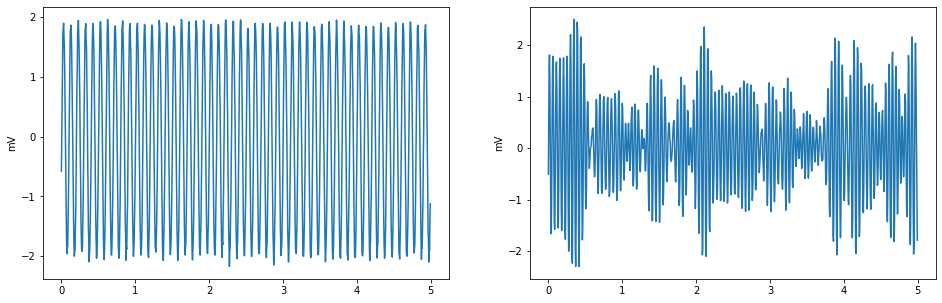

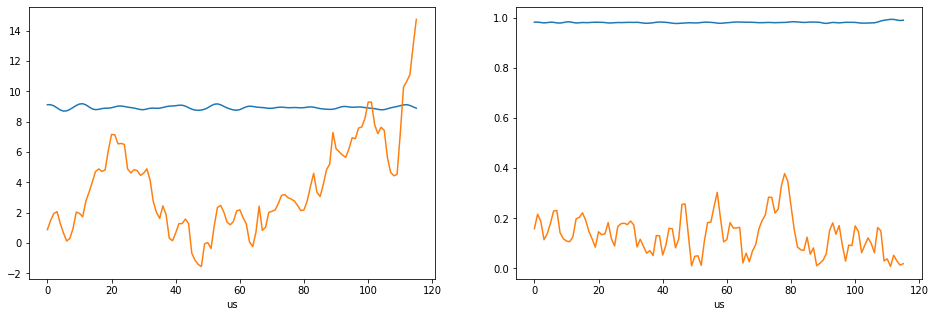

JKAMMMMMMMMMMMM00000.h5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
JKAMMMMMMMMMMMM00000.h5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
JKAMMMMMMMMMMMM00000.h5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [41]:
jkam_creation_time_array, avg_time_gap, jkam_shots = compute_jkam_creation_times()
rawgage_read(jkam_shots,
                get_shot_num(run_name, window, filter_time),
                check_gage_file_mismatch(run_name, window, filter_time)[0],
                check_gage_file_mismatch(run_name, window, filter_time)[1],
                num_segments,
                window,
                True,
                het_freq,
                dds_freq,
                samp_freq,
                step_time,
                filter_time,
                file_prefix_gage)